# Classification

## Introduction

Here we will take a look at **logistic regression** which is the baseline supervised machine learning algorithm for classification and tie in very closely to neural networks.

For simplicity we will consider classification between two classes which can then be extended to multiple classes typically known as **multinomial logistic regression**. 

## Classifiers

Let's first introduce classification/classifiers.

Classification is used to determine which *class* a set of *inputs signals* belong to.
- Classes are the outputs of a classifier typically determined by the designer in many cases but will largely depend on the application. 
- The set of input signals can be *any* signal that we can measure or obtain from some sensor or preprocessed data.
  - These input signals are typically called **features** or **feature vectors** which is an array where each element containing a single measurement/data point

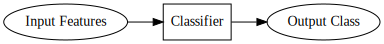

In [1]:
from graphviz import Digraph

g = Digraph(format='png')
g.graph_attr['rankdir'] = 'LR'

g.attr('node', shape='ellipse')
g.node('Input Features')
g.node('Output Class')

g.attr('node', shape='box')
g.node('Classifier')

g.edge('Input Features', 'Classifier')
g.edge('Classifier', 'Output Class')

#g.render()
g

### Features

For optimal classifiers, we'll typically want to use **salient features**, that is features that are highly distinguishable across classes.
  - ie) Measure color/channel pixel intensity between a lemon and an orange
Salient features are important because the ability to distinguish between classes is in the *variance* of the data.
  - It doesn't help to measure the curvature of a lemon and an orange since they are both very similar/invariant.
  
## Generative and Discriminative Classifiers

These are the two main different frameworks to build a machine learning model.
- A *generative* model attempts to capture an understanding of the features and can, as a result, generate sample features from this understanding.
  - Attempt to capture the (probability) distribution of the features
  - Utilizes the **likelihood** term, $P(d|c)$, which expresses how to generate features *if we knew it was a class of c*
  - Naive Bayes, Bayesian Networks, Markov Random Fields, Hidden Markov Models (HMM)
- A *discriminative* model will only distinguish the classes, possibly without learning much about the features.
  - Logistic Regression, Traditional Neural Networks, Nearest Neighbors
  - Attempts to directly compute the probability $P(c|d)$
  - Create decision boundaries or thresholds to distinguish classes

Knowledge is stored differently depending on a classifier and can be parametric or non-parametric.
  - Statistical
    - Knowledge stored in probability density functions (pdf)
  - Neural Networks
    - Knowledge stored in connectivity on synaptic weights
  - Decision Tree
    - Knowledge stored in decision thresholds and choices

---

# A Brief Overview

Let's look at a quick overview of generative models before we dive a bit further

In [2]:
import numpy as np
from numpy import matlib
import scipy.stats as stats
import matplotlib.pyplot as plt

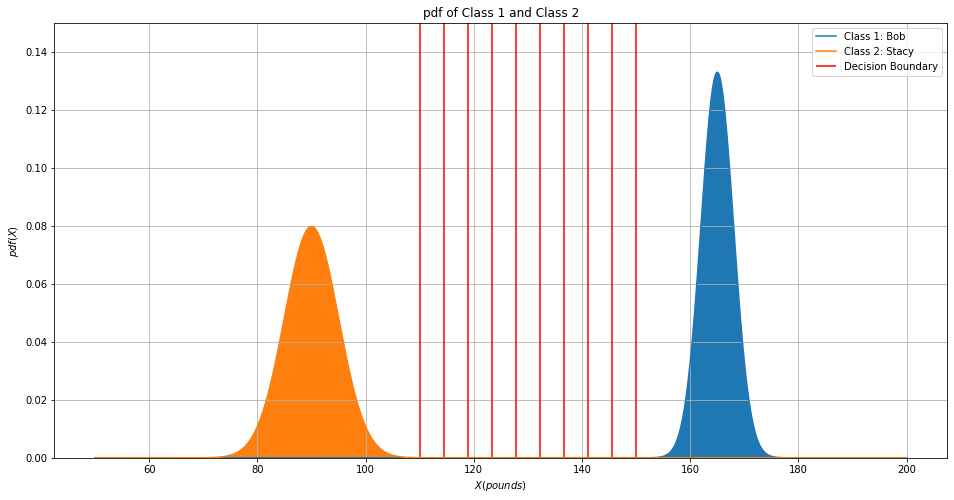

In [3]:
x_range = np.linspace(50, 200, 1000)
generate_distribution = lambda x: stats.skewnorm(a=x['skew'],
                                                 loc=x['mean'],
                                                 scale=x['stdev']
                                                )

# generate sample distribution for class 1
class_1 = {
    'mean': 165,
    'stdev': 3,
    'skew': 0
}
class_1_distribution = generate_distribution(class_1)
class_1_pdf_y = class_1_distribution.pdf(x_range)

# generate sample distribution for class 2
class_2 = {
    'mean': 90,
    'stdev': 5,
    'skew': 0
}
class_2_distribution = generate_distribution(class_2)
class_2_pdf_y = class_2_distribution.pdf(x_range)

# plot the two density functions
plt.figure(figsize=(16, 8))

c1, = plt.plot(x_range, class_1_pdf_y)
plt.fill_between(x_range, class_1_pdf_y)

c2, = plt.plot(x_range, class_2_pdf_y)
plt.fill_between(x_range, class_2_pdf_y)

boundary = plt.vlines([np.linspace(110, 150, 10)], 0, .15, 'r')
plt.ylim([0, .15])

plt.xlabel('$X (pounds)$')
plt.ylabel('$pdf(X)$')
plt.title('pdf of Class 1 and Class 2')
plt.legend((c1, c2, boundary), ['Class 1: Bob', 'Class 2: Stacy', 'Decision Boundary'])
plt.grid()

Let's look at the plot above and say that this is the pdf for two classes. Particularly, let's say that we measure the physical weight (as a feature) of two people Bob and Stacy which lie on the plots above.

Now this is a trival case to distinguish between the two classes given that this information is avaliable to us prior. It is trival due to the fact that there is a wide separation between the two features to the point where we can pick a decision boundary threshold between the two distributions.

- In the generative models, these distributions are attempted to be captured and thus are able to generate samples based on the classifier's interpretation of the distribution. We can therefore "ask" the model what the physical weight of Bob might be and it can generate those features.
- In the discrimitative models, a simple threshold is provided to discriminate the two classes as a decision boundary.

Trivial cases like these aren't typically a use case for classifiers but rather for when there is some ambiguity between classes. So let's take a look at a more, non-trivial case.

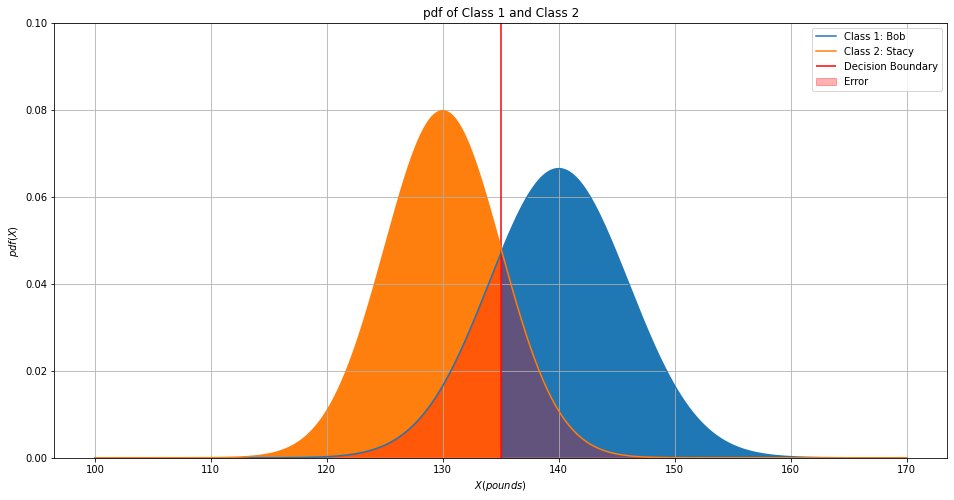

In [4]:
x_range = np.linspace(100, 170, 1000)
generate_distribution = lambda x: stats.skewnorm(a=x['skew'],
                                                 loc=x['mean'],
                                                 scale=x['stdev']
                                                )

# generate sample distribution for class 1
class_1 = {
    'mean': 140,
    'stdev': 6,
    'skew': 0
}
class_1_distribution = generate_distribution(class_1)
class_1_pdf_y = class_1_distribution.pdf(x_range)

# generate sample distribution for class 2
class_2 = {
    'mean': 130,
    'stdev': 5,
    'skew': 0
}
class_2_distribution = generate_distribution(class_2)
class_2_pdf_y = class_2_distribution.pdf(x_range)

# define decision boundary
decision_boundary = 135

# plot the two density functions
plt.figure(figsize=(16, 8))

c1, = plt.plot(x_range, class_1_pdf_y)
plt.fill_between(x_range[np.where(x_range > decision_boundary)],
                 class_1_pdf_y[np.where(x_range > decision_boundary)])

c2, = plt.plot(x_range, class_2_pdf_y)
plt.fill_between(x_range[np.where(x_range < decision_boundary)],
                 class_2_pdf_y[np.where(x_range < decision_boundary)])

err1 = plt.fill_between(x_range[np.where(x_range < decision_boundary)],
                 class_1_pdf_y[np.where(x_range < decision_boundary)], color='r', alpha=0.3)
err2 = plt.fill_between(x_range[np.where(x_range > decision_boundary)],
                 class_2_pdf_y[np.where(x_range > decision_boundary)], color='r', alpha=0.3)
boundary = plt.vlines([decision_boundary], 0, .2, 'r')
plt.ylim([0, .1])

plt.xlabel('$X (pounds)$')
plt.ylabel('$pdf(X)$')
plt.title('pdf of Class 1 and Class 2')
plt.legend((c1, c2, boundary, err1), ['Class 1: Bob', 'Class 2: Stacy', 'Decision Boundary', 'Error'])
plt.grid()

The decision boundary here is determined by minimizing the probability of error (misclassification).

The Bayes Decision Rule for minimum error:
$$
\begin{align}
\text{Pr}(\text{Error}) &= \text{Pr}(\text{Error}|C_1)\text{Pr}(C_1) + \text{Pr}(\text{Error}|C_2)\text{Pr}(C_2) \\
&= \text{Pr}(C_2|C_1)\text{Pr}(C_1) + \text{Pr}(C_1|C_2)\text{Pr}(C_2) \\
\end{align}
$$

This is typically known as the **likelihood ratio test** and **hypothesis testing**.

An assumption that the distribution of the data was gaussian/normal is used here which appears frequently. A gaussian distribution is simpler to work with and has a limited number of parameters (skew, mean, stdev) but the likelihood ratio test applies to other distributions as well.

## Shifting the Decision Boundary and Incorporating Risk/Cost

Note that if the example above, error is minimized, in fact, if we shift the decision boundary to either the left or the right, the probability of error increases.

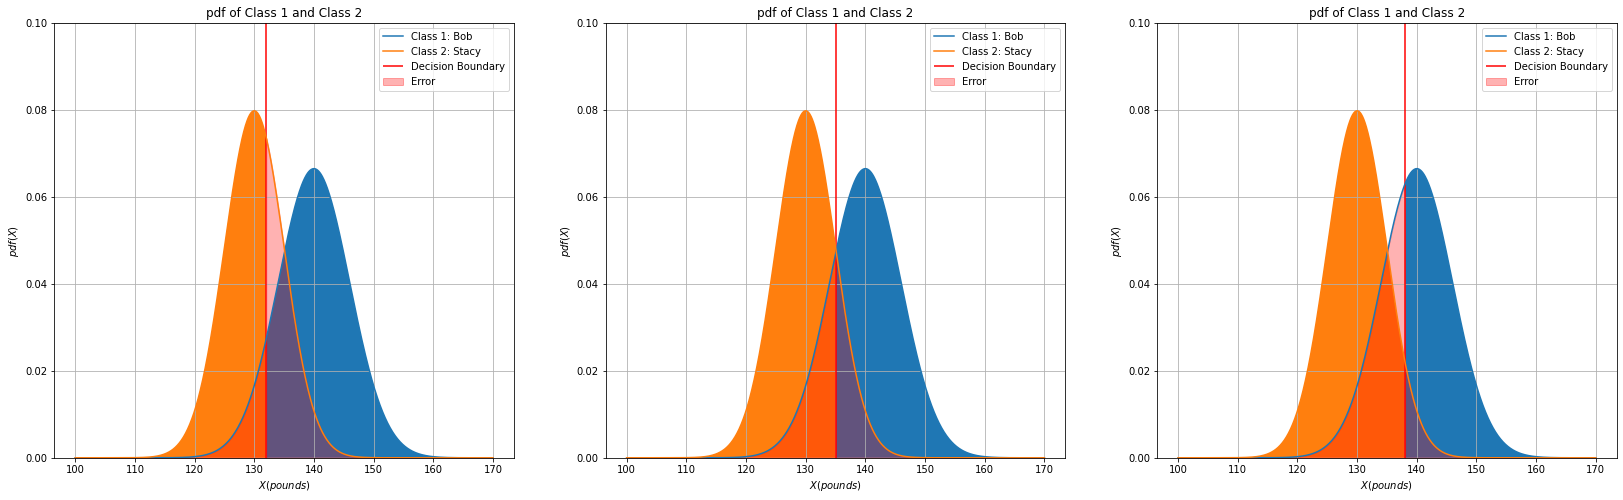

In [5]:
# define decision boundary
decision_boundaries = [132, 135, 138]

# plot the two density functions
plt.figure(figsize=(28, 8))

for plt_idx, decision_boundary in enumerate(decision_boundaries):
    plt.subplot(1, 3, plt_idx+1)
    c1, = plt.plot(x_range, class_1_pdf_y)
    plt.fill_between(x_range[np.where(x_range > decision_boundary)],
                     class_1_pdf_y[np.where(x_range > decision_boundary)])

    c2, = plt.plot(x_range, class_2_pdf_y)
    plt.fill_between(x_range[np.where(x_range < decision_boundary)],
                     class_2_pdf_y[np.where(x_range < decision_boundary)])

    err1 = plt.fill_between(x_range[np.where(x_range < decision_boundary)],
                     class_1_pdf_y[np.where(x_range < decision_boundary)], color='r', alpha=0.3)
    err2 = plt.fill_between(x_range[np.where(x_range > decision_boundary)],
                     class_2_pdf_y[np.where(x_range > decision_boundary)], color='r', alpha=0.3)
    boundary = plt.vlines([decision_boundary], 0, .2, 'r')
    plt.ylim([0, .1])

    plt.xlabel('$X (pounds)$')
    plt.ylabel('$pdf(X)$')
    plt.title('pdf of Class 1 and Class 2')
    plt.legend((c1, c2, boundary, err1), ['Class 1: Bob', 'Class 2: Stacy', 'Decision Boundary', 'Error'])
    plt.grid()

A cost or amount of risk can be applied to shift the decision boundary intentionally by some value to fit the application.

Take for example, a sensor that would measure a feature of a package, say possibly the amount of some chemical measured by an X-Ray machine, and it was the objective of the classifier to determine if the package contained an explosive or not.
- Being on the safe side of incurring additional error and misclassifying a package as a bomb when it really isn't would be much more ideal than the other way around (classifying a package as not a bomb when it is).
- At the other extreme, saying every package is a bomb is a waste of resource and likely impractical.

Mathematically, the ratio of costs are really all that matter when computing a decision boundary which minimizes the cost.

### ROC Curves

Reciever Operating Characteristic (ROC) curves can be used to determine cost by evaluating the classifier's response to it's probability for detection versus the probability for false alarm.

## Other Tests

### Minimax Test

Find the likelihood ratio threshold to minimize the maximum conditional errors.
  - Useful for when the priors are unknown and to have resonable performance for any priors

$$
\text{Pr}(\text{Error}) = \text{Pr}(\text{Error}|C_1)\text{Pr}(C_1) + \text{Pr}(\text{Error}|C_2)\text{Pr}(C_2) \\
\varepsilon_1 = \text{Pr}(\text{Error}|C_1) = \varepsilon_2 = \text{Pr}(\text{Error}|C_2)
$$

### Neyman-Pearson Criterion

Find the likelihood ratio threshold to maximize the probability of detection for a defined probability of false alarm.
  - Fix one of the conditional errors and minimize the other

## Multi-Class Classifier

Expansions into multiple classes can be done in several ways. A common way is to build a binary (2-class) classifier for each class to indicate if it **is** or **is not** the given class. Looking at multiple classes will be covered later but for many cases, a binary classifier helps portray many of the concepts easier and can be expanded to multiple classes.

# Expansion of Features

Currently we have only looked at a single feature, that is, a feature vector with only one dimension. Typically many features are used for a classifier in order to better represent the shape of the data and determine optimal decision boundaries. We can project an N-dimensional feature vector onto a plot where each axis is a feature. The N-dimensional space consisting of feature values is typically called the **feature space** or **hypercube**. The difficulty in working with working with high dimensional spaces is visualizing them beyond two or three dimension in a plot.

In [6]:
def gaussian_random_vectors(mean, cov, num_values, seed=None):
    n = len(mean)
    
    # get eigenvalues to compute spread
    evalues, evectors = np.linalg.eig(cov)

    # take absolute values incase eigenvalues are not positive semi-definite
    abs_values = np.abs(evalues)
    
    A = evectors * np.sqrt(abs_values)
    
    np.random.seed(seed)
    Y = np.random.randn(n, num_values)

    # transform to get target mean and covariance
    shift = np.matlib.repmat(mean, num_values, 1).T
    X = np.dot(A, Y) + shift
    
    return X

In [56]:
mean_1 = [72, 180]
cov_1 = [[1, 2], [4, 1]]  # diagonal covariance

mean_2 = [60, 150]
cov_2 = [[1, 0.1], [1, 1]]  # diagonal covariance

Text(0.5, 1.0, 'Feature Space')

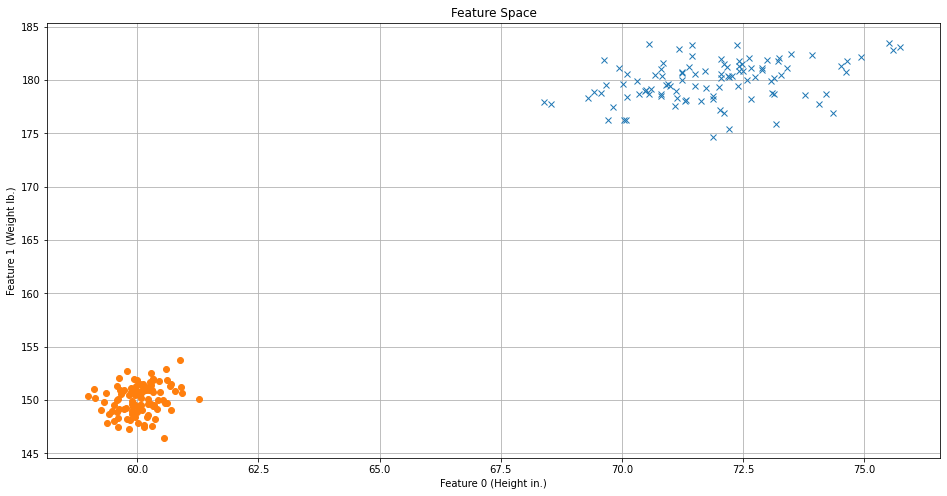

In [62]:
c1 = gaussian_random_vectors(mean_1, cov_1, 100)
c2 = gaussian_random_vectors(mean_2, cov_2, 100)

plt.figure(figsize=(16, 8))
plt.plot(c1[0], c1[1], 'x')
plt.plot(c2[0], c2[1], 'o')
plt.grid()
plt.xlabel('Feature 0 (Height in.)')
plt.ylabel('Feature 1 (Weight lb.)')
plt.title('Feature Space')